In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Follows tutorial fom here: https://docs.opencv.org/3.4/d4/dee/tutorial_optical_flow.html

In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import IPython.display as display

# Lucas-Kanade Optical Flow in OpenCV 

OpenCV provides all the whole Lucas-Kanade method in one function, cv.calcOpticalFlowPyrLK(). 

The following code shows a simple application which tracks some points in a video. To decide the points, we use cv.goodFeaturesToTrack(). We take the first frame, detect some Shi-Tomasi corner points in it, then we iteratively track those points using Lucas-Kanade optical flow. For the function cv.calcOpticalFlowPyrLK() we pass the previous frame, previous points and next frame. It returns next points along with some status numbers which has a value of 1 if next point is found, else zero. We iteratively pass these next points as previous points in next step. 

(Description adapted from the linked tutorial https://docs.opencv.org/3.4/d4/dee/tutorial_optical_flow.html).

The dynamic plotting in colab is a bit troublesome so there may be some flashing. If you want you can comment out the dynamic plotting code and just view the final result or manually plot only some intermediate frames in seperate plots using subplots.

No frames grabbed!


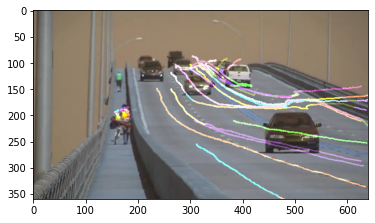

In [23]:
vid_path = ("drive/Shareddrives/(TA Team Drive) CIS 580 Machine Perception Fall 2022/Worksheets/Primer 7: Optical flow with OpenCV/Data/slow_traffic_small.mp4") #change this to the right path if you're running from your drive

cap = cv2.VideoCapture(vid_path)
# params for ShiTomasi corner detection
feature_params = dict( maxCorners = 100,
                       qualityLevel = 0.3,
                       minDistance = 7,
                       blockSize = 7 )
# Parameters for lucas kanade optical flow
lk_params = dict( winSize  = (15, 15),
                  maxLevel = 2,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))
# Create some random colors
color = np.random.randint(0, 255, (100, 3))
# Take first frame and find corners in it
ret, old_frame = cap.read()
old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
p0 = cv2.goodFeaturesToTrack(old_gray, mask = None, **feature_params)
# Create a mask image for drawing purposes
mask = np.zeros_like(old_frame)

j=0
while(True):
    ret, frame = cap.read()
    if not ret:
        print('No frames grabbed!')
        break
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    # calculate optical flow
    p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)
    # Select good points
    if p1 is not None:
        good_new = p1[st==1]
        good_old = p0[st==1]
    
    # draw the tracks
    for i, (new, old) in enumerate(zip(good_new, good_old)):
        a, b = new.ravel()
        c, d = old.ravel()
        mask = cv2.line(mask, (int(a), int(b)), (int(c), int(d)), color[i].tolist(), 2)
        frame = cv2.circle(frame, (int(a), int(b)), 5, color[i].tolist(), -1)

    img = cv2.add(frame, mask)

    

    #This will show the frames as it goes but it flashes a bit. 
    #You should comment it out and just visualize the last frame 
    #if flashing images cause you problems (it will also run faster)
    if((j%10)==0): #only plot every 10 frames to speed it up a bit
      try:
          plt.imshow(img)
          display.display(plt.gcf())
          display.clear_output(wait=True)
      except KeyboardInterrupt:
          break



    # Now update the previous frame and previous points
    old_gray = frame_gray.copy()
    p0 = good_new.reshape(-1, 1, 2)
    j+= 1

plt.imshow(img)

# Dense Optical Flow in OpenCV 

Lucas-Kanade method computes optical flow for a sparse feature set (in our example, corners detected using Shi-Tomasi algorithm). OpenCV provides another algorithm to find the dense optical flow. It computes the optical flow for all the points in the frame. It is based on Gunnar Farneback's algorithm which is explained in "Two-Frame Motion Estimation Based on Polynomial Expansion" by Gunnar Farneback in 2003.

Below sample shows how to find the dense optical flow using above algorithm. We get a 2-channel array with optical flow vectors, (u,v). We find their magnitude and direction. We color code the result for better visualization. Direction corresponds to Hue value of the image. Magnitude corresponds to Value plane. 

(From think linked tutorial https://docs.opencv.org/3.4/d4/dee/tutorial_optical_flow.html)

You can try running the two methods with the other provided video or one of your own. When is it better to use sparse optical flow or dense optical flow?

No frames grabbed!


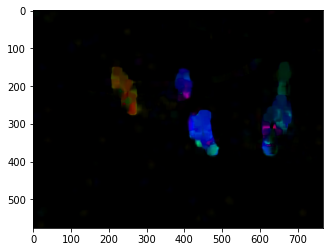

In [29]:
vid2_path = ("drive/Shareddrives/(TA Team Drive) CIS 580 Machine Perception Fall 2022/Worksheets/Primer 7: Optical flow with OpenCV/Data/vtest.avi") #change this to the right path if you're running from your drive

cap = cv2.VideoCapture(vid2_path)

ret, frame1 = cap.read()
prvs = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
hsv = np.zeros_like(frame1)
hsv[..., 1] = 255
j = 0
while(True):
    ret, frame2 = cap.read()
    if not ret:
        print('No frames grabbed!')
        break

    next = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)
    flow = cv2.calcOpticalFlowFarneback(prvs, next, None, 0.5, 3, 15, 3, 5, 1.2, 0)
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    hsv[..., 0] = ang*180/np.pi/2
    hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
    bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    

    #This will show the frames as it goes but it flashes a bit. 
    #You should comment it out and just visualize the last frame 
    #if flashing images cause you problems 
    #(it will also run faster, although this one is slow even without plotting)
    try:
        plt.imshow(bgr)
        display.display(plt.gcf())
        display.clear_output(wait=True)
    except KeyboardInterrupt:
        break

    prvs = next
    j+= 1
plt.imshow(bgr)